In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
import hvplot.xarray  # noqa
import seaborn as sns
from dask import delayed, compute
import itertools
from pytmatrix import tmatrix_aux, refractive, tmatrix, radar
from pymiecoated import Mie
from scipy.constants import c
from scipy import stats as ss
from scipy.optimize import minimize
from scipy.optimize import brentq
from scipy.special import gamma
from sqlalchemy.exc import OperationalError
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from re import split
import matplotlib.dates as mdates
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
from dask import delayed, compute
from metpy.calc import pressure_to_height_std as p2h
from metpy.calc import lcl
import cartopy.crs as ccrs
import cartopy
import cartopy.mpl.ticker as cticker
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import warnings
import cython
warnings.filterwarnings('ignore')



sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
cluster = SLURMCluster(queue="seseml",
                       memory='50GB',
                       cores=40,
                       processes=1,
                       walltime='24:00:00', 
#                        scheduler_options={
#                            'host': '172.22.179.3:7224', 
#                            'dashboard_address': ':7798'
#                        }
                      )

cluster.scale(jobs=1)
cluster

In [3]:
client = Client(cluster)
client

<Client: 'tcp://172.22.179.184:41905' processes=0 threads=0, memory=0 B>

In [4]:
%%bash
squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1656755    seseml interact alfonso8  R       3:53      1 keeling-j54
           1656757    seseml dask-wor alfonso8  R       0:01      1 keeling-j55


In [5]:
aircraft = 'Lear'
aircraft2 = 'Learjet'
aircraft1 = 'P3B'
aircraft3 = 'P3B'

In [6]:
store = f"{path_data}/cloud_probes/zarr/dm_retrieved_Lear.zarr"
store1 = f"{path_data}/cloud_probes/zarr/combined_psd_Lear_600_1000_5_bins_merged.zarr"
store2 = f"{path_data}/cloud_probes/zarr/combined_psd_P3B_600_1000_5_bins_merged.zarr"
store3 = f"{path_data}/cloud_probes/zarr/dm_retrieved_P3B.zarr"


In [18]:
dm_lear = xr.open_zarr(store)
dm_p3b = xr.open_zarr(store3)

In [19]:
# xr_comb = xr.concat([xr_lear, xr_p3b], dim='time')

In [20]:
ds_dm = xr.concat([dm_lear, dm_p3b], dim='time')

In [21]:
def metrics(x, xpred):
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x) 
    corr = xr.corr(x, xpred).compute()**2.
    return rmse.compute().values, mae.compute().values, corr.values

def metrics_pd(x, xpred):
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x) 
    corr = np.corrcoef(x, xpred)**2.
    return rmse, mae, corr[0, 1]

In [22]:
rmse, mae, corr1 = metrics(ds_dm.dm_true, ds_dm.dm_rt_dfr_nd)

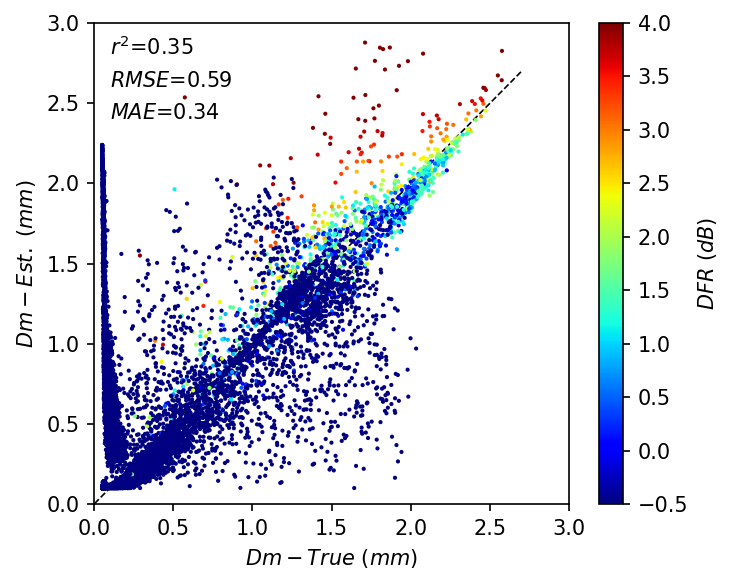

In [23]:
fig, ax1 = plt.subplots(dpi=150, figsize=(5, 4))

sc1 = ax1.scatter(ds_dm.dm_true, 
                  ds_dm.dm_rt_dfr_nd, 
                  s=1, zorder=10, 
                  c=ds_dm.dfr, cmap='jet', vmin=-0.5, vmax=4)

ax1.set_ylabel(r"$Dm-Est. \ (mm) $")
x = np.linspace(*ax1.get_xlim())

ax1.set_xlabel(r"$Dm-True \ (mm) $")
ax1.text(0.1, 2.8, r"$r^2$" + f"={corr1:.2f}")
ax1.text(0.1, 2.6, r"$RMSE$" + f"={rmse:.2f}")
ax1.text(0.1, 2.4, r"$MAE$" + f"={mae:.2f}")
fig.colorbar(sc1, ax=ax1, label=r'$DFR \ (dB)$')
ax1.plot(x, x, c='k', ls='--', lw=0.8)
ax1.set_xlim(0, 3)
ax1.set_ylim(0, 3)
plt.tight_layout()
plt.savefig('../results/dm_gm.jpeg')

In [24]:
rmse, mae, corr1 = metrics(ds_dm.dm_true, ds_dm.dm_rt_dfr_nd)

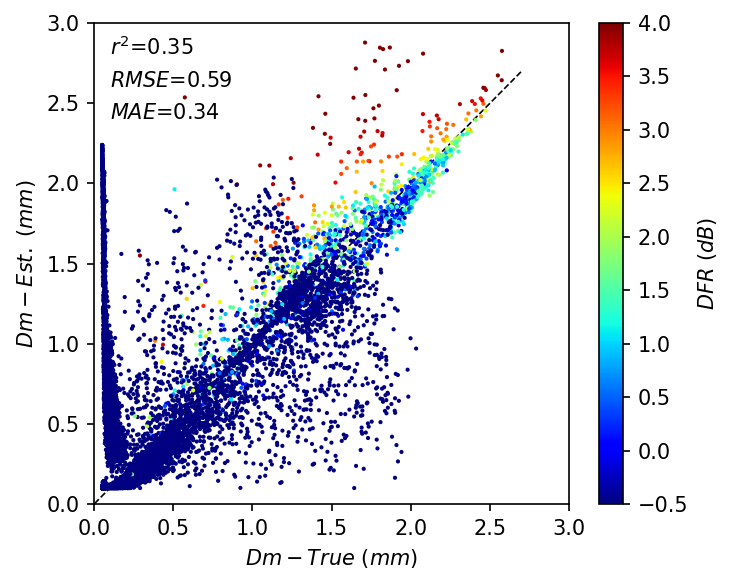

In [25]:
fig, ax1 = plt.subplots(dpi=150, figsize=(5, 4))

sc1 = ax1.scatter(ds_dm.dm_true, 
                  ds_dm.dm_rt_dfr_nd, 
                  s=1, zorder=10, 
                  c=ds_dm.dfr, cmap='jet', vmin=-0.5, vmax=4)

ax1.set_ylabel(r"$Dm-Est. \ (mm) $")
x = np.linspace(*ax1.get_xlim())

ax1.set_xlabel(r"$Dm-True \ (mm) $")
ax1.text(0.1, 2.8, r"$r^2$" + f"={corr1:.2f}")
ax1.text(0.1, 2.6, r"$RMSE$" + f"={rmse:.2f}")
ax1.text(0.1, 2.4, r"$MAE$" + f"={mae:.2f}")
fig.colorbar(sc1, ax=ax1, label=r'$DFR \ (dB)$')
ax1.plot(x, x, c='k', ls='--', lw=0.8)
ax1.set_xlim(0, 3)
ax1.set_ylim(0, 3)
plt.tight_layout()
plt.savefig('../results/dm_nd.jpeg')

In [26]:
rmse, mae, corr1 = metrics(ds_dm.dm_true, ds_dm.dm_rt_dfr_gm_mu_3)

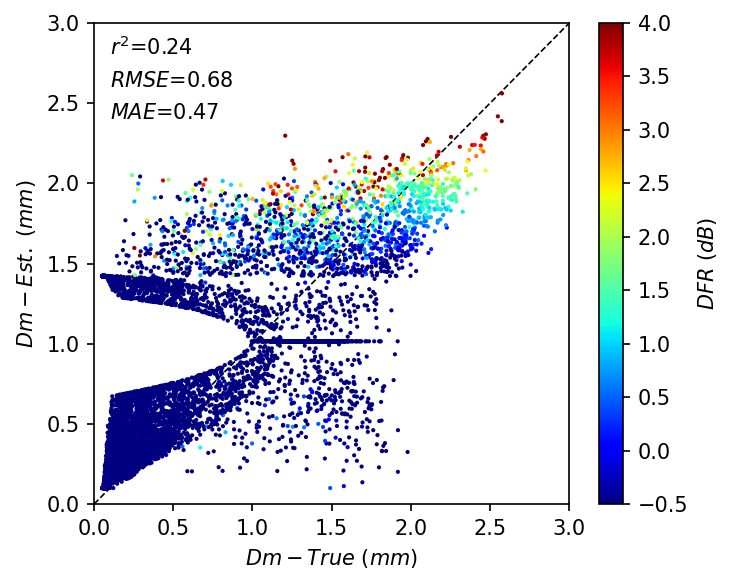

In [27]:
fig, ax = plt.subplots( dpi=150, figsize=(5, 4))
sc = ax.scatter(ds_dm.dm_true, 
                ds_dm.dm_rt_dfr_gm_mu_3, 
                c=ds_dm.dfr, cmap='jet', vmin=-0.5, vmax=4, s=1, zorder=10)
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
ax.text(0.1, 2.8, r"$r^2$" + f"={corr1:.2f}")
ax.text(0.1, 2.6, r"$RMSE$" + f"={rmse:.2f}")
ax.text(0.1, 2.4, r"$MAE$" + f"={mae:.2f}")
ax.set_ylabel(r"$Dm-Est. \ (mm) $")
ax.set_xlabel(r"$Dm-True \ (mm) $")
fig.colorbar(sc, ax=ax, label=r'$DFR \ (dB)$')
plt.tight_layout()
plt.savefig('../results/dm_gpm.jpeg')

In [28]:
df = ds_dm[['log10nw_true', 'log10nw_true_mu_dm']].to_dataframe()
df = df.replace([np.inf, -np.inf], np.nan).dropna()
rmse, mae, corr1 = metrics_pd(df['log10nw_true'], df['log10nw_true_mu_dm'])
print(rmse, mae, corr1)

0.5407472147628248 0.4044621465970415 0.9991483853135463


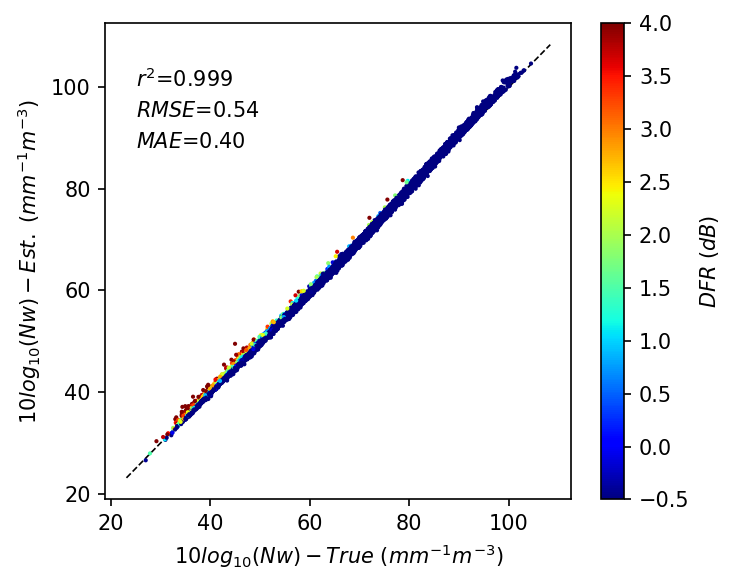

In [29]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
sc = ax.scatter(ds_dm.log10nw_true,
                ds_dm.log10nw_true_mu_dm, 
                c=ds_dm.dfr, cmap='jet', vmin=-0.5, vmax=4, s=1, zorder=10)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
ax.set_ylabel(r"$10log_{10}(Nw)-Est. \ (mm^{-1} m^{-3}) $")
ax.set_xlabel(r"$10log_{10}(Nw)-True \ (mm^{-1} m^{-3})$")
ax.text(25, 100, r"$r^2$" + f"={corr1:.3f}")
ax.text(25, 94, r"$RMSE$" + f"={rmse:.2f}")
ax.text(25, 88, r"$MAE$" + f"={mae:.2f}")
fig.colorbar(sc, ax=ax, label=r'$DFR \ (dB)$')
plt.tight_layout()
plt.savefig('../results/nw_gm.jpeg')

38.22466324699078 24.19494040160432 0.0020351040275603843


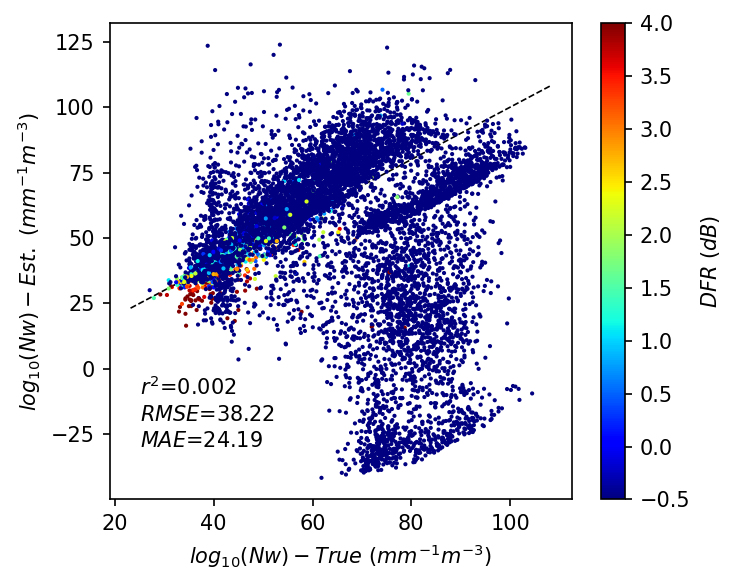

In [43]:
df = ds_dm[['log10nw_true', 'log10nw_dm_nd']].to_dataframe()
df = df.replace([np.inf, -np.inf], np.nan).dropna()
rmse, mae, corr1 = metrics_pd(df['log10nw_true'], df['log10nw_dm_nd'])
print(rmse, mae, corr1)

fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
sc = ax.scatter(ds_dm.log10nw_true,
                ds_dm.log10nw_dm_nd, 
                c=ds_dm.dfr, cmap='jet', vmin=-0.5, vmax=4, s=1, zorder=10)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
ax.set_ylabel(r"$log_{10}(Nw)-Est. \ (mm^{-1} m^{-3}) $")
ax.set_xlabel(r"$log_{10}(Nw)-True \ (mm^{-1} m^{-3})$")
ax.text(25, -10, r"$r^2$" + f"={corr1:.3f}")
ax.text(25, -20, r"$RMSE$" + f"={rmse:.2f}")
ax.text(25, -30, r"$MAE$" + f"={mae:.2f}")
fig.colorbar(sc, ax=ax, label=r'$DFR \ (dB)$')
plt.tight_layout()
plt.savefig('../results/nw_nd.jpeg')

In [31]:
df = ds_dm[['log10nw_true', 'log10nw_dm_gm_mu_3']].to_dataframe()
df = df.replace([np.inf, -np.inf], np.nan).dropna()
rmse, mae, corr1 = metrics_pd(df['log10nw_true'], df['log10nw_dm_gm_mu_3'])
print(rmse, mae, corr1)

43.453391647038096 29.00891219904598 0.07552243910781838


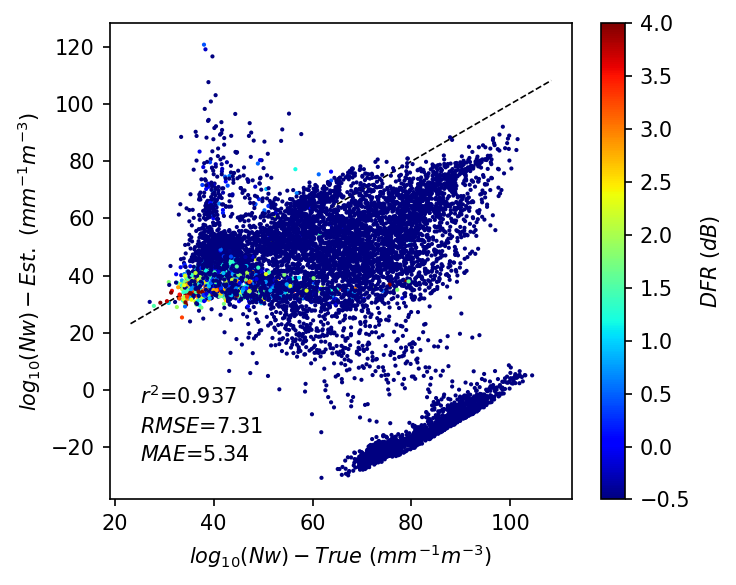

In [42]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
sc = ax.scatter(ds_dm.log10nw_true, 
                ds_dm.log10nw_dm_gm_mu_3,
                c=ds_dm.dfr, cmap='jet', vmin=-0.5, vmax=4, s=1, zorder=10)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
ax.set_ylabel(r"$log_{10}(Nw)-Est. \ (mm^{-1} m^{-3}) $")
ax.set_xlabel(r"$log_{10}(Nw)-True \ (mm^{-1} m^{-3})$")
ax.text(25, -5, r"$r^2$" + f"={corr1:.3f}")
ax.text(25, -15, r"$RMSE$" + f"={rmse:.2f}")
ax.text(25, -25, r"$MAE$" + f"={mae:.2f}")
fig.colorbar(sc, ax=ax, label=r'$DFR \ (dB)$')
plt.tight_layout()
plt.savefig('../results/nw_gpm.jpeg')

In [33]:
# rmse, mae, corr1 = metrics(ds_dm.r_true, ds_dm.r_true_nw_mu_dm)
df = ds_dm[['r_true', 'r_true_nw_mu_dm']].to_dataframe()
df = df.replace([np.inf, -np.inf], np.nan).dropna()
rmse, mae, corr1 = metrics_pd(df['r_true'], df['r_true_nw_mu_dm'])
print(rmse, mae, corr1)

290.4157356917318 13.39349836173578 0.00489521558960367


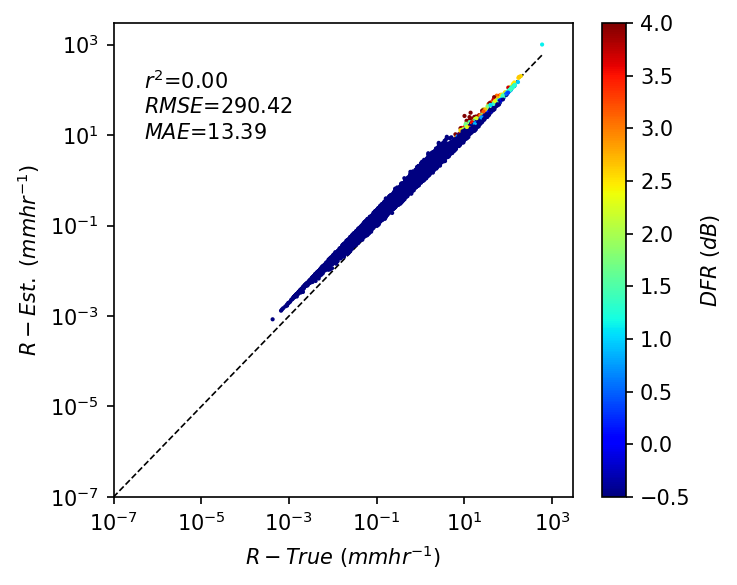

In [34]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
sc = ax.scatter(ds_dm.r_true, 
                ds_dm.r_true_nw_mu_dm, 
                c=ds_dm.dfr, cmap='jet', vmin=-0.5, vmax=4, s=1, zorder=10)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
ax.set_ylabel(r"$R-Est. \ (mm hr^{-1}) $")
ax.set_xlabel(r"$R -True \ (mm hr^{-1})$")
ax.text(0.0000005, 105, r"$r^2$" + f"={corr1:.2f}")
ax.text(0.0000005, 30, r"$RMSE$" + f"={rmse:.2f}")
ax.text(0.0000005, 8, r"$MAE$" + f"={mae:.2f}")
ax.set_xlim(0.0000001, 3000)
ax.set_ylim(0.0000001, 3000)
fig.colorbar(sc, ax=ax, label=r'$DFR \ (dB)$')
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()
plt.savefig('../results/r_gm.jpeg')

In [35]:
# rmse, mae, corr1 = metrics(ds_dm.r_true, ds_dm.r_true_nw_mu_dm)
df = ds_dm[['r_true', 'r_dm_gm_mu_3']].to_dataframe()
df = df.replace([np.inf, -np.inf], np.nan).dropna()
rmse, mae, corr1 = metrics_pd(df['r_true'], df['r_dm_gm_mu_3'])
print(rmse, mae, corr1)

319.7916182383834 23.58012162847638 0.0002001180734009105


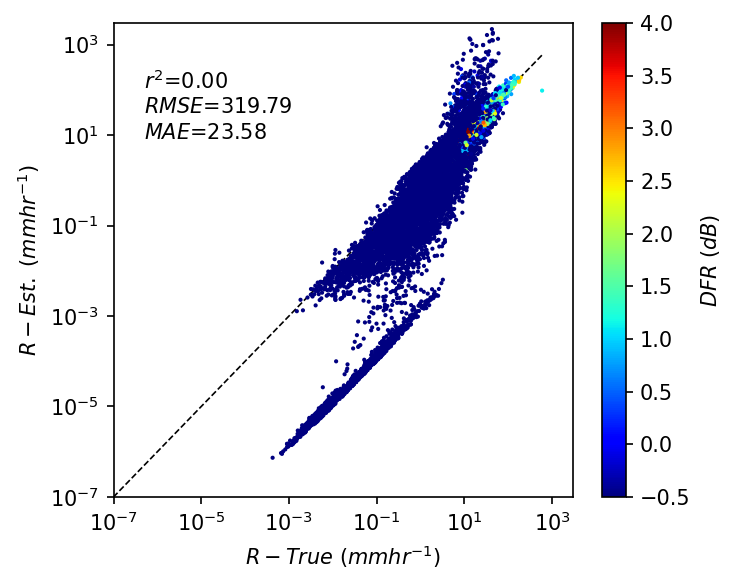

In [36]:
fig, ax1 = plt.subplots(figsize=(5, 4), dpi=150)

sc1 = ax1.scatter(ds_dm.r_true, 
                  ds_dm.r_dm_gm_mu_3, 
                   c=ds_dm.dfr, cmap='jet', vmin=-0.5, vmax=4, s=1, zorder=10)
# x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
ax1.set_ylabel(r"$R-Est. \ (mm hr^{-1}) $")
ax1.set_xlabel(r"$R -True \ (mm hr^{-1})$")
ax1.text(0.0000005, 105, r"$r^2$" + f"={corr1:.2f}")
ax1.text(0.0000005, 30, r"$RMSE$" + f"={rmse:.2f}")
ax1.text(0.0000005, 8, r"$MAE$" + f"={mae:.2f}")
ax1.set_xlim(0.0000001, 3000)
ax1.set_ylim(0.0000001, 3000)
fig.colorbar(sc1, ax=ax1, label=r'$DFR \ (dB)$')
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.tight_layout()
plt.savefig('../results/r_gpm.jpeg')

405.8252497988457 41.76592890388696 0.0001992641633952662


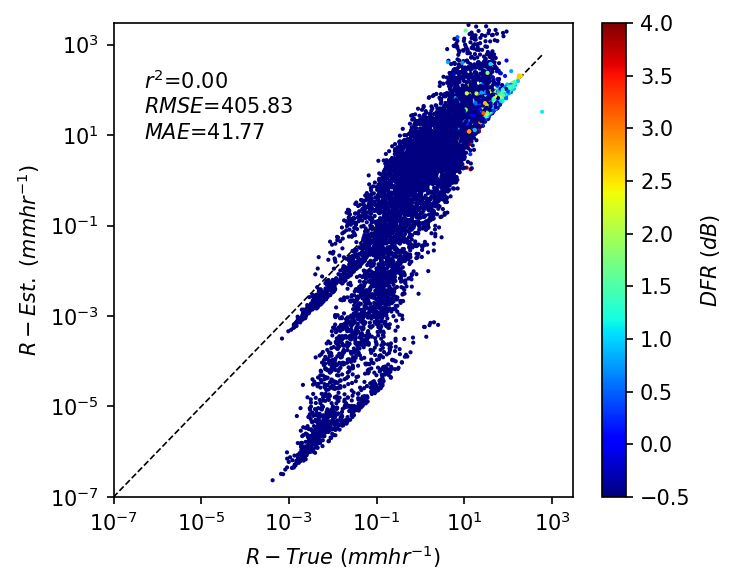

In [37]:
# rmse, mae, corr1 = metrics(ds_dm.r_true, ds_dm.r_true_nw_mu_dm)
df = ds_dm[['r_true', 'r_dm_nd']].to_dataframe()
df = df.replace([np.inf, -np.inf], np.nan).dropna()
rmse, mae, corr1 = metrics_pd(df['r_true'], df['r_dm_nd'])
print(rmse, mae, corr1)

fig, ax1 = plt.subplots(figsize=(5, 4), dpi=150)

sc1 = ax1.scatter(ds_dm.r_true, 
                  ds_dm.r_dm_nd, 
                   c=ds_dm.dfr, cmap='jet', vmin=-0.5, vmax=4, s=1, zorder=10)
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
ax1.set_ylabel(r"$R-Est. \ (mm hr^{-1}) $")
ax1.set_xlabel(r"$R -True \ (mm hr^{-1})$")
ax1.text(0.0000005, 105, r"$r^2$" + f"={corr1:.2f}")
ax1.text(0.0000005, 30, r"$RMSE$" + f"={rmse:.2f}")
ax1.text(0.0000005, 8, r"$MAE$" + f"={mae:.2f}")
ax1.set_xlim(0.0000001, 3000)
ax1.set_ylim(0.0000001, 3000)
fig.colorbar(sc1, ax=ax1, label=r'$DFR \ (dB)$')
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.tight_layout()
plt.savefig('../results/r_nd.jpeg')

In [38]:
x_bins = [-10, -0.5, 0.0, 0.5, 1.0, 1.5, 10]
x_bin_labels = [-10, -0.5, 0.0, 0.5, 1.0, 1.5]
title = ["DFR < -0.5", "-0.5 < DFR < 0.0", "0.0 < DFR < 0.5", "0.5 < DFR < 1.0", "1.0 < DFR < 1.5", "DFR > 1.5"]

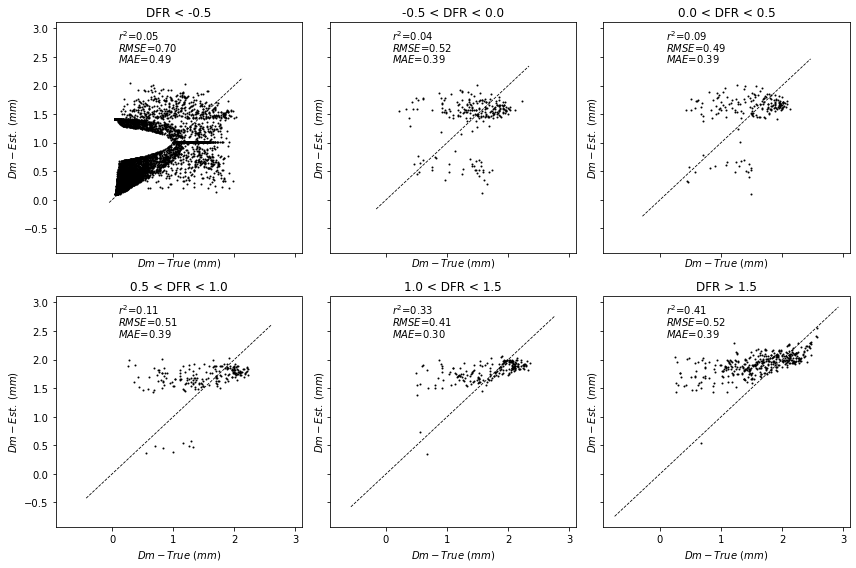

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
grouped =  ds_dm.groupby_bins(ds_dm.dfr, x_bins, labels=x_bin_labels)

for i, ax in enumerate(axes.flat):
    try:
        ds = grouped[x_bin_labels[i]]    
        df = ds[['dm_true', 'dm_rt_dfr_gm_mu_3']].to_dataframe()
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
        rmse, mae, corr1 = metrics_pd(df['dm_true'], df['dm_rt_dfr_gm_mu_3'])
        sc = ax.scatter(ds.dm_true,
                        ds.dm_rt_dfr_gm_mu_3, c='k', s=1)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x, c='k', ls='--', lw=0.8)
        ax.text(0.1, 2.8, r"$r^2$" + f"={corr1:.2f}")
        ax.text(0.1, 2.6, r"$RMSE$" + f"={rmse:.2f}")
        ax.text(0.1, 2.4, r"$MAE$" + f"={mae:.2f}")
        ax.set_ylabel(r"$Dm-Est. \ (mm) $")
        ax.set_xlabel(r"$Dm-True \ (mm) $")
        ax.set_title(title[i])
        plt.tight_layout()
    except IndexError:
        continue
plt.savefig('../results/dm_gpm_bins.jpeg')

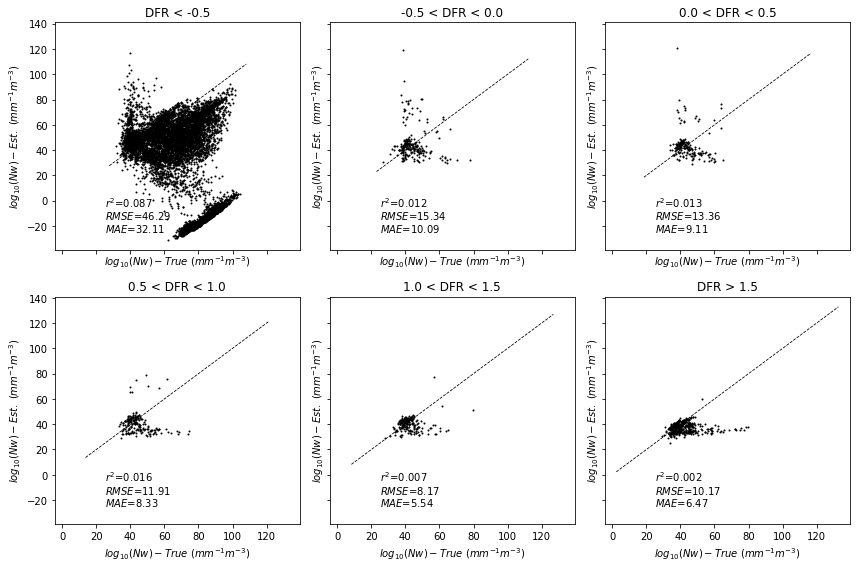

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
grouped =  ds_dm.groupby_bins(ds_dm.dfr, x_bins, labels=x_bin_labels)

for i, ax in enumerate(axes.flat):
    try:
        ds = grouped[x_bin_labels[i]]    
        df = ds[['log10nw_true', 'log10nw_dm_gm_mu_3']].to_dataframe()
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
        rmse, mae, corr1 = metrics_pd(df['log10nw_true'], df['log10nw_dm_gm_mu_3'])
        sc = ax.scatter(ds.log10nw_true, 
                        ds.log10nw_dm_gm_mu_3, c='k', s=1)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x, c='k', ls='--', lw=0.8)
        ax.set_ylabel(r"$log_{10}(Nw)-Est. \ (mm^{-1} m^{-3}) $")
        ax.set_xlabel(r"$log_{10}(Nw)-True \ (mm^{-1} m^{-3})$")
        ax.text(25, -5, r"$r^2$" + f"={corr1:.3f}")
        ax.text(25, -15, r"$RMSE$" + f"={rmse:.2f}")
        ax.text(25, -25, r"$MAE$" + f"={mae:.2f}")
        ax.set_title(title[i])
        plt.tight_layout()
    except IndexError:
        continue
plt.savefig('../results/nw_gpm_bins.jpeg')

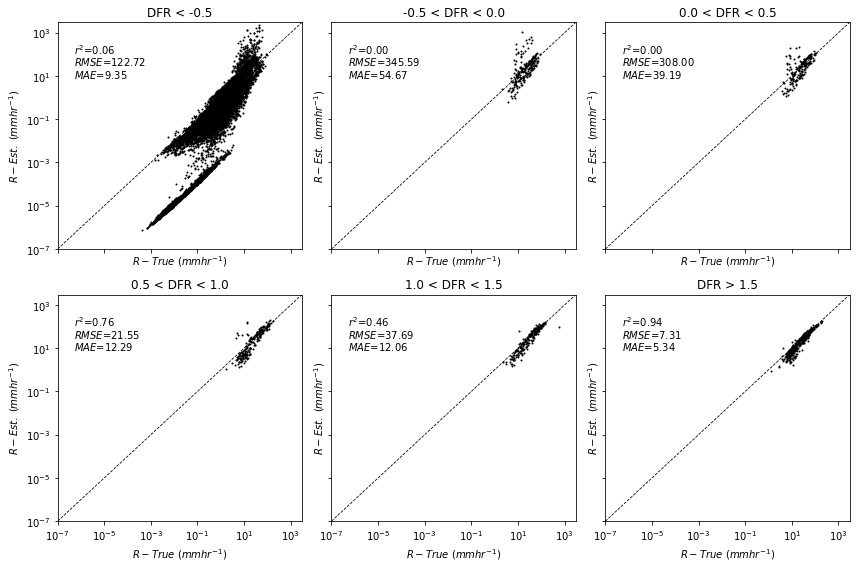

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
grouped =  ds_dm.groupby_bins(ds_dm.dfr, x_bins, labels=x_bin_labels)
for i, ax in enumerate(axes.flat):
    try:
        ds = grouped[x_bin_labels[i]]    
        df = ds[['r_true', 'r_dm_gm_mu_3']].to_dataframe()
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
        rmse, mae, corr1 = metrics_pd(df['r_true'], df['r_dm_gm_mu_3'])
        sc1 = ax.scatter(ds.r_true, 
                          ds.r_dm_gm_mu_3, c='k', s=1)
        x = np.linspace(*ax1.get_xlim())
        ax.plot(x, x, c='k', ls='--', lw=0.8)
        ax.set_ylabel(r"$R-Est. \ (mm hr^{-1}) $")
        ax.set_xlabel(r"$R -True \ (mm hr^{-1})$")
        ax.text(0.0000005, 105, r"$r^2$" + f"={corr1:.2f}")
        ax.text(0.0000005, 30, r"$RMSE$" + f"={rmse:.2f}")
        ax.text(0.0000005, 8, r"$MAE$" + f"={mae:.2f}")
        ax.set_xlim(0.0000001, 3000)
        ax.set_ylim(0.0000001, 3000)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_title(title[i])
        plt.tight_layout()
    except IndexError:
        continue
plt.savefig('../results/r_gpm_bins.jpeg')

In [52]:
ds_dm.where(ds_dm.dfr < 0, drop=True)

<xarray.Dataset>
Dimensions:             (time: 8346, dm: 3900)
Coordinates:
  * dm                  (dm) float64 0.1 0.101 0.102 0.103 ... 3.997 3.998 3.999
  * time                (time) datetime64[ns] 2019-09-07T00:50:13 ... 2019-10...
Data variables: (12/25)
    dfr                 (time) float64 dask.array<chunksize=(3307,), meta=np.ndarray>
    dfr_gm              (time) float64 dask.array<chunksize=(3307,), meta=np.ndarray>
    dm_rt_dfr           (time) float64 dask.array<chunksize=(3307,), meta=np.ndarray>
    dm_rt_dfr_gm        (time) float64 dask.array<chunksize=(3307,), meta=np.ndarray>
    dm_rt_dfr_gm_mu_3   (time) float64 dask.array<chunksize=(3307,), meta=np.ndarray>
    dm_rt_dfr_nd        (time) float64 dask.array<chunksize=(3307,), meta=np.ndarray>
    ...                  ...
    r_dm_gm             (time) float64 dask.array<chunksize=(3307,), meta=np.ndarray>
    r_dm_gm_mu_3        (time) float64 dask.array<chunksize=(3307,), meta=np.ndarray>
    r_dm_nd             (time) float64 dask.array<chunksize=(3307,), meta=np.ndarray>
    r_gpm               (time) float64 dask.array<chunksize=(3307,), meta=np.ndarray>
    r_true              (time) float64 dask.array<chunksize=(3307,), meta=np.ndarray>
    r_true_nw_mu_dm     (time) float64 dask.array<chunksize=(3307,), meta=np.ndarray>